# Indian start-up ecosystem

Your team is trying to venture into the Indian start-up ecosystem. As the data expert of the team, you are to investigate the ecosystem and propose the best course of action.
Analyze funding received by start-ups in India from 2018 to 2021.
Separate data for each year of funding will be provided.
• In these datasets, you'll find the start-ups' details, the funding amounts received, and the investors' information

In [1]:
import pyodbc
from dotenv import dotenv_values
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import f_oneway
import statistics as stat
import warnings
import os

warnings.filterwarnings('ignore')

In [2]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

In [3]:
conn_str =f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [4]:
connection = pyodbc.connect(conn_str)

query1 = "Select * from LP1_startup_funding2020"
data2020 = pd.read_sql(query1, connection)

query2 = "Select * from LP1_startup_funding2021"
data2021 = pd.read_sql(query2, connection)

In [5]:
df2018 = pd.read_csv('startup_funding2018.csv')

df2019 = pd.read_csv('startup_funding2019.csv')

# STEP 1

In [ ]:
# Add a Year Colunm

In [6]:
df2018['Year']='2018'
df2019['Year']='2019'
data2020['Year']='2020'
data2021['Year']='2021'

# STEP 2

Clean and Concat the 2 csv file 2018&2019

In [7]:
# Drop the Colunms You see no use keeping

df2019.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)


In [8]:
# Select specific columns and rename them

df2018 = df2018.rename(columns={'Company Name': 'Company_Brand', 'Round/Series': 'Stage', 'Industry': 'Sector', 'Amount': 'Amount', 'About Company': 'BIO', 'Location':'HeadQuarter'})
df2019 = df2019.rename(columns={'Company/Brand': 'Company_Brand', 'Sector': 'Sector', 'Stage': 'Stage', 'Amount($)': 'Amount', 'What it does': 'BIO', 'HeadQuarter':'HeadQuarter'})


<b>Harmonising the Stage column entries in 2018&2019 data.<b>

In [9]:
# df2018 Dataframe 

df2018.replace(to_replace=['Seed round', 'Seed funding', 'Early seed', 'Seed fund', 'Seed Investment', 'Seed Round', 'Seed+'], value='Seed', inplace=True)
df2018.replace(to_replace=['Angel Round'], value='Angel', inplace=True)
df2018.replace(to_replace=['Venture - Series Unknown'], value='Undisclosed', inplace=True)
df2018.replace(to_replace=['Debt Financing', 'Post-IPO Debt'], value='Debt', inplace=True)
df2018.replace(to_replace=['Private Equity', 'Post-IPO Equity'], value='Equity', inplace=True)
df2018.replace(to_replace=['Corporate Round', 'Grant', 'Secondary Market', 'Non-equity Assistance', 'Funding Round'], value='Other', inplace=True)
df2018.replace(to_replace=['Pre-Series B', 'Pre-series B'], value='Pre-Seed', inplace=True)

In [10]:
# df2019 Dataframe

df2019.replace(to_replace=['Seed funding', 'Seed fund', 'Seed round'], value='Seed', inplace=True)
df2019.replace(to_replace=['Pre series A', 'Pre-series A'], value='Pre-Seed', inplace=True)
df2019.replace(to_replace=['Series B+'], value='Series B', inplace=True)
df2019.replace(to_replace=['Post series A', 'Fresh funding'], value='Other', inplace=True)

In [11]:
# Remove non-standard entries

df2018 = df2018[df2018['Stage'].str.startswith('https') == False]

<b>Harmonising the HeadQuater/Location column entries in 2018&2019 data.<b>

In [12]:
# data cleaning of headquarter in 2018

df2018.replace(to_replace=['Bangalore City','Bangalore'], value='Bangalore', inplace=True)
df2018.replace(to_replace=['Delhi','New Delhi'], value='Delhi', inplace=True)
df2018.replace(to_replace=['Cochin'], value='Kochi', inplace=True)
df2018.replace(to_replace=['Kormangala'], value='Koramangala', inplace=True)
df2018.replace(to_replace=['Powai','Worli'], value='Mumbai', inplace=True)
df2018.replace(to_replace=['Uttar Pradesh', 'Andhra Pradesh'], value='Andhra Pradesh', inplace=True)
df2018.replace(to_replace=['Trivandrum', 'India'], value='Trivandrum', inplace=True)

In [13]:
# data cleaning of headquarter in 2019

df2019.replace(to_replace=['Delhi' , 'New Delhi'], value='Delhi', inplace=True)

<b>Harmonising the Sector column entries in 2018&2019 data.<b>

In [14]:
# data cleaning of Sector in 2019

df2019['Tech'] = df2019['Sector'].apply(lambda x: x if 'Tech' in str(x) or 'tech' in str(x) or 'AI' in str(x) or 'IoT' in str(x) else None)
df2019['Non_tech'] = df2019['Sector'].apply(lambda x: x if 'Tech' not in str(x) and 'tech' not in str(x)
                                                       and 'AI' not in str(x) and 'IoT' not in str(x) else None)

In [15]:
# data cleaning of Sector in 2018

df2018['Tech'] = df2018['Sector'].apply(lambda x: x if 'Tech' in str(x) or 'tech' in str(x) or 'AI' in str(x) or 'IoT' in str(x) else None)
df2018['Non_tech'] = df2018['Sector'].apply(lambda x: x if 'Tech' not in str(x) and 'tech' not in str(x)
                                                       and 'AI' not in str(x) and 'IoT' not in str(x) else None)

In [16]:
df2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 525 entries, 0 to 525
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Company_Brand  525 non-null    object
 1   Sector         525 non-null    object
 2   Stage          525 non-null    object
 3   Amount         525 non-null    object
 4   HeadQuarter    525 non-null    object
 5   BIO            525 non-null    object
 6   Year           525 non-null    object
 7   Tech           80 non-null     object
 8   Non_tech       445 non-null    object
dtypes: object(9)
memory usage: 41.0+ KB


In [17]:
df2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Company_Brand  89 non-null     object
 1   HeadQuarter    70 non-null     object
 2   Sector         84 non-null     object
 3   BIO            89 non-null     object
 4   Amount         89 non-null     object
 5   Stage          43 non-null     object
 6   Year           89 non-null     object
 7   Tech           39 non-null     object
 8   Non_tech       45 non-null     object
dtypes: object(9)
memory usage: 6.4+ KB


<b>CHECK FOR DUPLICATE ENTRIES IN THE NEW DATASET df2018 & df2019<b>

In [21]:
df2018.duplicated().value_counts()

False    524
Name: count, dtype: int64

In [20]:
df2018.drop_duplicates(keep='first', inplace=True)

In [19]:
df2019.duplicated().value_counts()

False    89
Name: count, dtype: int64

# STEP 3

Currency Convertion 

In [22]:
# Merge the two csv files 

df18_19 = pd.concat([df2018, df2019], ignore_index=True)

In [23]:
# Create a new column 'currency' based on currency symbols

df18_19['currency'] = df18_19['Amount'].apply(lambda x: 'INR' if '₹' in x else ('USD' if '$' in x else 'USD'))

In [24]:
# Create columns 'amount_inr' and 'amount_usd'

df18_19['amount_inr'] = df18_19.apply(lambda row: row['Amount'] if row['currency'] == 'INR' else 0, axis=1)
df18_19['amount_usd'] = df18_19.apply(lambda row: row['Amount'] if row['currency'] == 'USD' else 0, axis=1)

In [25]:
# Remove the currency sysmbols and the commas 

df18_19['amount_inr'] = df18_19['amount_inr'].str.replace('₹', '').str.replace('$', '').str.replace(',', '')
df18_19['amount_usd'] = df18_19['amount_usd'].str.replace('₹', '').str.replace('$', '').str.replace(',', '')

In [26]:
# Replace 'Undisclosed' values with NaN

df18_19['amount_inr'] = df18_19['amount_inr'].replace('Undisclosed', np.nan, regex=True)
df18_19['amount_usd'] = df18_19['amount_usd'].replace('Undisclosed', np.nan, regex=True)

In [27]:
# Convert the object values into numeric values for calculation

df18_19['amount_inr'] = pd.to_numeric(df18_19['amount_inr'], errors='coerce')
df18_19['amount_usd'] = pd.to_numeric(df18_19['amount_usd'], errors='coerce')

In [28]:
# Define the exchange rate
exchange_rate_inr_to_usd = 1 / 83.23  # 1 USD = 83.23 INR

# Convert 'amount_inr' to USD
df18_19['amount_inr'] = df18_19['amount_inr'].apply(lambda x: x * exchange_rate_inr_to_usd if x is not None else None)

In [29]:
# Create a new column 'Updated_Amount' by filling missing values in 'amount_inr' with 'amount_usd'
df18_19['Updated_Amount'] = df18_19['amount_inr'].fillna(df18_19['amount_usd'])

In [31]:
df18_19.duplicated().value_counts()

False    613
Name: count, dtype: int64

# STEP 4

Clean and Concat the 2 sql file 2020&2021

In [32]:
# Renaming the Column

data2020 = data2020.rename(columns={'Company_Brand': 'Company_Brand', 'Sector': 'Sector', 'Amount': 'Amount', 'What_it_does': 'BIO', 'Location':'HeadQuarter'})
data2021 = data2021.rename(columns={'Company_Brand': 'Company_Brand', 'Sector': 'Sector', 'Amount': 'Amount', 'What_it_does': 'BIO', 'HeadQuarter':'HeadQuarter'})

# Drop a columns you see no need of keeping

In [33]:
data2020.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)
data2021.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)
data2020.drop(columns=['column10'], inplace=True)

# CLEANING THE DATAFRAMES 

<b>Harmonising the Stage column entries in 2020&2021 data.<b>

In [34]:
# data2020 DataFrame 

data2020.replace(to_replace=['Seed Round', 'Seed round', 'Seed funding', 'Seed A', 'Seed Funding', 'Seed Investment','Pre seed Round', 'Seed funding' 'Seed A' 'Pre-seed', 'Pre seed round', 'Pre-seed Round', 'Pre-Seed'], value='Seed', inplace=True)
data2020.replace(to_replace=['Series A1', 'Series A-1'], value='Series A', inplace=True)
data2020.replace(to_replace=['Series B2'], value='Series B', inplace=True)
data2020.replace(to_replace=['Pre series B', 'Pre-Series B', 'Pre series C', 'Pre-Series B' 'Pre series C','Pre series A1', 'Pre-series', 'Pre series A', 'Pre-series A', 'Pre- series A', 'Pre Series A', 'Pre-series A1', 'Pre-series C', 'Pre-series B'], value='Pre-Series', inplace=True)
data2020.replace(to_replace=['Series E', 'Series E2', 'Series F'], value='Series E and Beyond', inplace=True)
data2020.replace(to_replace=['Series C, D', 'Series D', 'Series D1'], value='Series D', inplace=True)
data2020.replace(to_replace=['Bridge Round', 'Edge', 'Bridge'], value='Bridge', inplace=True)
data2020.replace(to_replace=['Angel Round'], value='Angel', inplace=True)

In [35]:
# data2021 DataFrame

data2021.replace(to_replace=['Seed Round', 'Seed round', 'Seed funding', 'Seed A', 'Seed+', 'Seed Funding', 'Seed Investment','Pre seed Round', 'Early seed', 'Seed funding' 'Seed A' 'Pre-seed', 'Pre seed round', 'Pre-seed', 'Pre-seed Round', 'Pre-Seed'], value='Seed', inplace=True)
data2021.replace(to_replace=['Series A1', 'Seies A', 'Series A2', 'Series A+', 'Series A-1'], value='Series A', inplace=True)
data2021.replace(to_replace=['Series B2', 'Series B3'], value='Series B', inplace=True)
data2021.replace(to_replace=['Pre series B', 'Pre-Series B', 'Pre series C', 'Pre-Series B' 'Pre series C','Pre series A1', 'Pre-series', 'Pre series A', 'Pre-series A', 'Pre- series A', 'Pre Series A', 'Pre-series A1', 'Pre-series C', 'Pre-series B'], value='Pre-Series', inplace=True)
data2021.replace(to_replace=['Series E', 'Series I', 'Series F1', 'Series H', 'Series G', 'Series F2', 'Series E2', 'Series F'], value='Series E and Beyond', inplace=True)
data2021.replace(to_replace=['Series C, D', 'Series D', 'Series D1'], value='Series D', inplace=True)
data2021.replace(to_replace=['Bridge Round', 'Edge', 'Bridge'], value='Bridge', inplace=True)
data2021.replace(to_replace=['Angel Round', '$300000', '$1200000', '$6000000', '$1000000'], value='Angel', inplace=True)

<b>Harmonising the Sector column entries in 2020&2021 data.<b>

In [36]:
# data cleaning of Sector in 2020

data2020['Tech'] = data2020['Sector'].apply(lambda x: x if 'Tech' in str(x) or 'tech' in str(x) or 'AI' in str(x) or 'IoT' in str(x) else None)
data2020['Non_tech'] = data2020['Sector'].apply(lambda x: x if 'Tech' not in str(x) and 'tech' not in str(x)
                                                       and 'AI' not in str(x) and 'IoT' not in str(x) else None)

In [37]:
# data cleaning of Sector in 2021

data2021['Tech'] = data2021['Sector'].apply(lambda x: x if 'Tech' in str(x) or 'tech' in str(x) or 'AI' in str(x) or 'IoT' in str(x) else None)
data2021['Non_tech'] = data2021['Sector'].apply(lambda x: x if 'Tech' not in str(x) and 'tech' not in str(x)
                                                       and 'AI' not in str(x) and 'IoT' not in str(x) else None)

<b>Harmonising the HeadQuarter column entries in 2020&2021 data.<b>

In [38]:
data2021.replace(to_replace=['London', 'New York', ' Mountain View', 'CA ', 'Beijing', '' ], value='Outside_India', inplace=True)
data2021.replace(to_replace=['Online Media\t#REF!', 'Pharmaceuticals\t#REF!', 'Food & Beverages', 
                             'Computer Games', 'Small Towns', ' None', 'None', 'Information Technology & Services'], value='Undisclosed', inplace=True)
data2021.replace(to_replace=['Gurugram\t#REF!' ], value='Gurugrama', inplace=True)

<b>CHECK FOR DUPLICATE ENTRIES IN THE NEW DATASET df2018 & df2019<b>

In [42]:
data2020.duplicated().value_counts()

False    1050
Name: count, dtype: int64

In [41]:
data2020.drop_duplicates(keep='first', inplace=True)

In [44]:
data2021.duplicated().value_counts()

False    1189
Name: count, dtype: int64

In [43]:
data2021.drop_duplicates(keep='first', inplace=True)

# STEP 5

Currency Convertion 

In [45]:
# Merge the two sql files 

df20_21 = pd.concat([data2020, data2021], ignore_index=True)

In [46]:
df20_21

,Company_Brand,HeadQuarter,Sector,BIO,Amount,Stage,Year,Tech,Non_tech
0,Aqgromalin,Chennai,AgriTech,Cultivating Ideas for Profit,200000.0,None,2020,AgriTech,None
1,Krayonnz,Bangalore,EdTech,An academy-guardian-scholar centric ecosystem ...,100000.0,Pre-seed,2020,EdTech,None
2,PadCare Labs,Pune,Hygiene management,Converting bio-hazardous waste to harmless waste,NaN,Pre-seed,2020,None,Hygiene management
3,NCOME,New Delhi,Escrow,Escrow-as-a-service platform,400000.0,None,2020,None,Escrow
4,Gramophone,Indore,AgriTech,Gramophone is an AgTech platform enabling acce...,340000.0,None,2020,AgriTech,None
...,...,...,...,...,...,...,...,...,...
2234,Gigforce,Gurugram,Staffing & Recruiting,A gig/on-demand staffing company.,$3000000,Pre-Series,2021,None,Staffing & Recruiting
2235,Vahdam,New Delhi,Undisclosed,VAHDAM is among the world’s first vertically i...,$20000000,Series D,2021,None,Undisclosed
2236,Leap Finance,Bangalore,Financial Services,International education loans for high potenti...,$55000000,Series C,2021,None,Financial Services
2237,CollegeDekho,Gurugram,EdTech,"Collegedekho.com is Student’s Partner, Friend ...",$26000000,Series B,2021,EdTech,None


In [47]:
# Create a new column 'Updated_Amount' by filling missing values in 'amount_inr' with 'amount_usd'

df20_21['Updated_Amount'] = df20_21['Amount']

In [48]:
# Create a column 'with_$' for values with '$' sign and 'without_$' for values without '$'

df20_21['with_$'] = df20_21['Updated_Amount'].apply(lambda x: x if '$' in str(x) else None)
df20_21['without_$'] = df20_21['Updated_Amount'].apply(lambda x: x if '$' not in str(x) else None)


In [49]:
# Remove the currency sysmbols and the commas 

df20_21['with_$'] = df20_21['with_$'].str.replace('$', '')


In [50]:
# Replace 'Undisclosed' values with NaN

df20_21['with_$'] = df20_21['with_$'].replace('Undisclosed', np.nan, regex=True)

In [51]:
# Convert the object values into numeric values for calculation

df20_21['with_$'] = pd.to_numeric(df20_21['with_$'], errors='coerce')
df20_21['without_$'] = pd.to_numeric(df20_21['without_$'], errors='coerce')

In [52]:
# Merge the two Colunms into a new colunm 

df20_21['Updated_Amount'] = df20_21['without_$'].fillna(df20_21['with_$'])

In [53]:
df20_21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239 entries, 0 to 2238
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company_Brand   2239 non-null   object 
 1   HeadQuarter     2145 non-null   object 
 2   Sector          2226 non-null   object 
 3   BIO             2239 non-null   object 
 4   Amount          1983 non-null   object 
 5   Stage           1358 non-null   object 
 6   Year            2239 non-null   object 
 7   Tech            895 non-null    object 
 8   Non_tech        1331 non-null   object 
 9   Updated_Amount  1402 non-null   float64
 10  with_$          605 non-null    float64
 11  without_$       797 non-null    float64
dtypes: float64(3), object(9)
memory usage: 210.0+ KB


In [54]:
df18_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company_Brand   613 non-null    object 
 1   Sector          608 non-null    object 
 2   Stage           567 non-null    object 
 3   Amount          613 non-null    object 
 4   HeadQuarter     594 non-null    object 
 5   BIO             613 non-null    object 
 6   Year            613 non-null    object 
 7   Tech            119 non-null    object 
 8   Non_tech        489 non-null    object 
 9   currency        613 non-null    object 
 10  amount_inr      144 non-null    float64
 11  amount_usd      309 non-null    float64
 12  Updated_Amount  453 non-null    float64
dtypes: float64(3), object(10)
memory usage: 62.4+ KB


# Merging All the Files 

In [55]:
df18_19.drop(['amount_usd', 'amount_inr', 'currency'], axis=1, inplace=True)
df20_21.drop(['without_$', 'with_$'], axis=1, inplace=True)


In [106]:
india_startup_df = pd.concat([df18_19, df20_21], ignore_index=True)

In [91]:
india_startup_df

,Company_Brand,Sector,Stage,Amount,HeadQuarter,BIO,Year,Tech,Non_tech,Updated_Amount,Industry
0,TheCollegeFever,"Brand Marketing, Event Promotion, Marketing, S...",Seed,250000,"Bangalore, Karnataka, India","TheCollegeFever is a hub for fun, fiesta and f...",2018,None,"Brand Marketing, Event Promotion, Marketing, S...",2.500000e+05,"Brand Marketing, Event Promotion, Marketing, S..."
1,Happy Cow Dairy,"Agriculture, Farming",Seed,"₹40,000,000","Mumbai, Maharashtra, India",A startup which aggregates milk from dairy far...,2018,None,"Agriculture, Farming",4.805959e+05,"Agriculture, Farming"
2,MyLoanCare,"Credit, Financial Services, Lending, Marketplace",Series A,"₹65,000,000","Gurgaon, Haryana, India",Leading Online Loans Marketplace in India,2018,None,"Credit, Financial Services, Lending, Marketplace",7.809684e+05,"Credit, Financial Services, Lending, Marketplace"
3,PayMe India,"Financial Services, FinTech",Angel,2000000,"Noida, Uttar Pradesh, India",PayMe India is an innovative FinTech organizat...,2018,"Financial Services, FinTech",None,2.000000e+06,"Financial Services, FinTech"
4,Eunimart,"E-Commerce Platforms, Retail, SaaS",Seed,—,"Hyderabad, Andhra Pradesh, India",Eunimart is a one stop solution for merchants ...,2018,None,"E-Commerce Platforms, Retail, SaaS",NaN,"E-Commerce Platforms, Retail, SaaS"
...,...,...,...,...,...,...,...,...,...,...,...
2847,Gigforce,Staffing & Recruiting,Pre-Series,$3000000,Gurugram,A gig/on-demand staffing company.,2021,None,Staffing & Recruiting,3.000000e+06,Staffing & Recruiting
2848,Vahdam,Undisclosed,Series D,$20000000,New Delhi,VAHDAM is among the world’s first vertically i...,2021,None,Undisclosed,2.000000e+07,Undisclosed
2849,Leap Finance,Financial Services,Series C,$55000000,Bangalore,International education loans for high potenti...,2021,None,Financial Services,5.500000e+07,Financial Services
2850,CollegeDekho,EdTech,Series B,$26000000,Gurugram,"Collegedekho.com is Student’s Partner, Friend ...",2021,EdTech,None,2.600000e+07,EdTech


In [90]:
# Create a new column 'Updated_Amount' by filling missing values in 'amount_inr' with 'amount_usd'
india_startup_df['Industry'] = india_startup_df['Tech'].fillna(india_startup_df['Non_tech'])

In [58]:

# Fill missing values in the specific column with 0.0
india_startup_df['Updated_Amount'].fillna(0.0, inplace=True)
india_startup_df['Amount'].fillna(0.0, inplace=True)



In [60]:
# Fill missing values in  with "unknown"
india_startup_df.fillna("NaN", inplace=True)

In [62]:
india_startup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2852 entries, 0 to 2851
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company_Brand   2852 non-null   object 
 1   Sector          2852 non-null   object 
 2   Stage           2852 non-null   object 
 3   Amount          2852 non-null   object 
 4   HeadQuarter     2852 non-null   object 
 5   BIO             2852 non-null   object 
 6   Year            2852 non-null   object 
 7   Tech            2852 non-null   object 
 8   Non_tech        2852 non-null   object 
 9   Updated_Amount  2852 non-null   float64
dtypes: float64(1), object(9)
memory usage: 222.9+ KB


Null Hypothesis: 

The total funding received by Indian startups has been increasing over the years (from 2018 to 2021).

Explanation: This hypothesis focuses on the trend in total funding over time. 

Calculate the total funding received by all startups for each year (2018, 2019, 2020, 2021).
Create a time series plot or line chart to visualize the funding trend over the four years.

In [63]:
india_startup_df['Stage'].value_counts()

Stage
unknown                  927
Seed                     743
Series A                 308
Pre-Series               303
Series B                 138
Series C                 113
Debt                      60
Series D                  53
Angel                     46
Series E and Beyond       41
Undisclosed               39
Other                     19
Pre-Seed                  15
Equity                    13
Pre-seed                  11
Bridge                    10
Series E                   6
Series H                   2
Series F                   1
Series G                   1
Seed Round & Series A      1
Mid series                 1
PE                         1
Name: count, dtype: int64

In [64]:
# Calculate the count of missing values in a specific column
missing_values_count = india_startup_df['Updated_Amount'].isna()
missing_values_count


0       False
1       False
2       False
3       False
4       False
        ...  
2847    False
2848    False
2849    False
2850    False
2851    False
Name: Updated_Amount, Length: 2852, dtype: bool

In [95]:
data2020['HeadQuarter'].value_counts()

HeadQuarter
Bangalore                                                   316
Mumbai                                                      163
Gurugram                                                     79
Delhi                                                        62
Chennai                                                      43
                                                           ... 
Newcastle Upon Tyne, Newcastle upon Tyne, United Kingdom      1
Shanghai, China                                               1
Jiaxing, Zhejiang, China                                      1
Rajastan                                                      1
Sydney, New South Wales, Australia                            1
Name: count, Length: 77, dtype: int64

In [69]:
# Get the Sum

total_funding = india_startup_df.groupby('')['Updated_Amount'].mean()

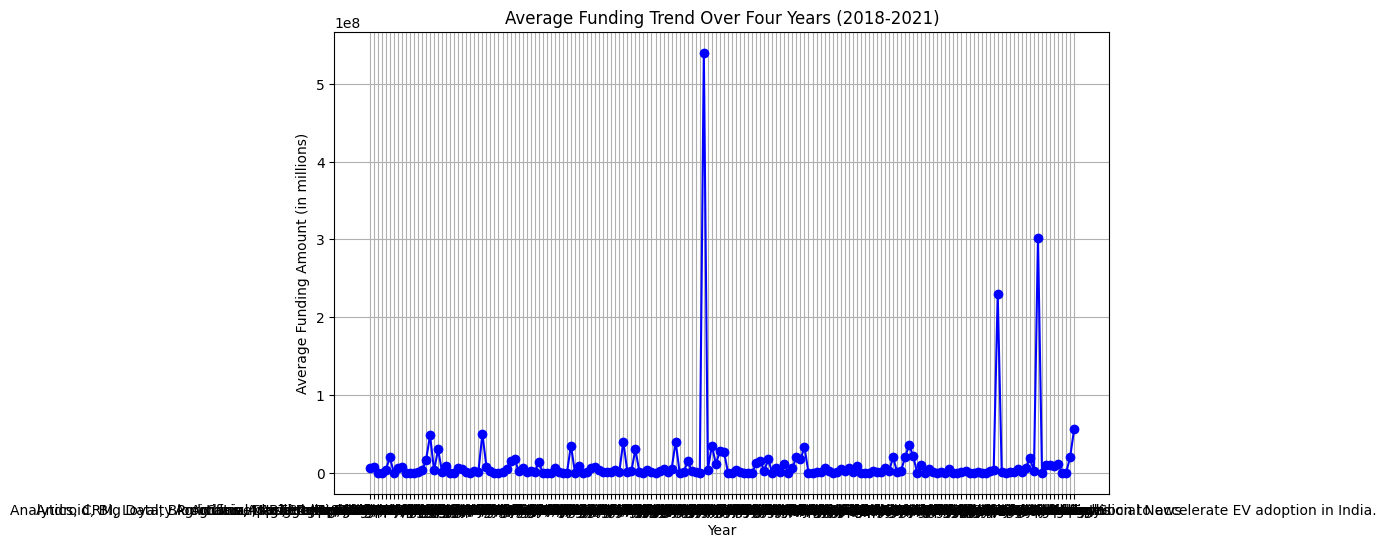

In [70]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(total_funding.index, total_funding.values, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Average Funding Amount (in millions)')
plt.title('Average Funding Trend Over Four Years (2018-2021)')
plt.grid(True)
plt.show()

Null Hypothesis:

The headquarters location of a startup in India (e.g., Chennai, Bangalore, Pune, New Delhi, Indore) has an impact on the funding amount it receives.

Explanation: 
The location of a startup's headquarters may influence its access to funding. For example, we might expect that startups in major startup hubs like Bangalore receive larger amounts of funding compared to those in smaller cities. 

ANOVA or Kruskal-Wallis Test: To determine if there are significant differences in funding amounts between startups in different cities.


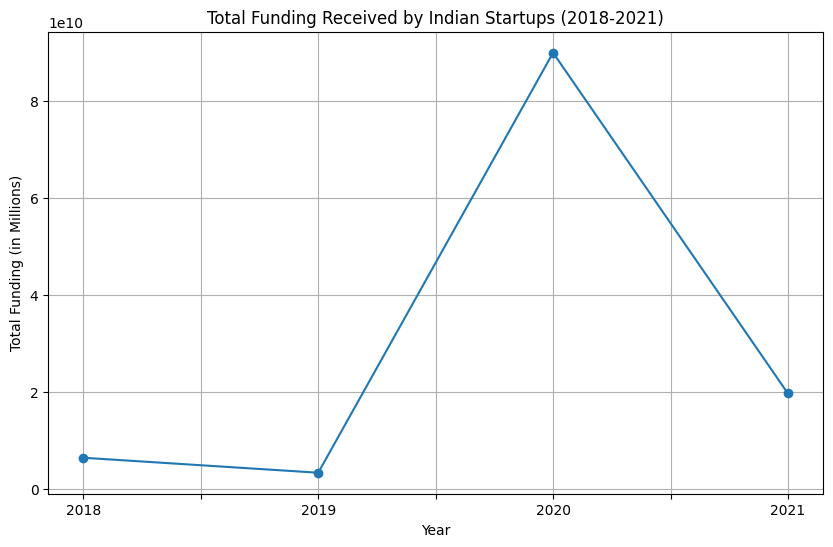

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'Amount' is the column containing the financial amounts
# Assuming 'Year' is the column containing the years

# Group by year and calculate the total funding for each year
total_funding_by_year = india_startup_df.groupby('Year')['Updated_Amount'].sum()

# Create a time series plot or line chart
plt.figure(figsize=(10, 6))
total_funding_by_year.plot(marker='o', linestyle='-')
plt.title('Total Funding Received by Indian Startups (2018-2021)')
plt.xlabel('Year')
plt.ylabel('Total Funding (in Millions)')
plt.grid(True)
plt.show()


In [297]:


# Extract unique locations from the 'HeadQuarter' 
locations = india_startup_df['HeadQuarter'].unique()

# Groupy data by headquarter
groups = [india_startup_df[india_startup_df['HeadQuarter'] == location ]['Updated_Amount']
for location in locations]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*groups)

# Check the p-value to determine statistical significance
if p_value < 0.05:
    print("There is a significant difference in funding amounts between cities.")
else:
    print("There is no significant difference in funding amounts between cities.")


There is no significant difference in funding amounts between cities.


# Analytic Question

1.)Trend Analysis: Is there a noticeable trend in the total funding received by Indian startups from 2018 to 2021? Are the funding amounts increasing or decreasing over the years?

2.)Sector Analysis: Which sector received the highest average funding in 2019, and has it changed in 2020 and 2021? Are there sectors that consistently attract more funding over the years?

3.)Location Impact: Do startups headquartered in specific cities or regions (e.g., Bangalore, Mumbai, Chennai) tend to receive more funding on average? Is there a correlation between the location of a startup and its funding amount?

4.)Stage of Funding: Are there significant differences in average funding amounts based on the funding stage (e.g., Seed, Series A, Series D) of the startups? How does the stage of funding impact the funding received by startups?

5.)Correlation between Sectors and Funding Stages: Is there a relationship between the sector of a startup and its funding stage? For example, do startups in the EdTech sector tend to receive more funding at a specific stage compared to startups in other sectors?


In [55]:
import matplotlib.pyplot as plt

# Selecting numerical columns
numeric_columns = df2018.select_dtypes(include='number').columns

# Check if 'Updated_Amount' is in numeric_columns
if 'Updated_Amount' in numeric_columns:
    # Create subplots
    fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(10, 5 * len(numeric_columns)))

    # Plot each numerical column
    for i, column in enumerate(numeric_columns):
        df2018[column].plot(ax=axes[i], kind='hist', title=column)
        axes[i].set_xlabel(column)

    plt.tight_layout()
    plt.show()
else:
    print("'Updated_Amount' not found in numerical columns.")


'Updated_Amount' not found in numerical columns.


In [82]:
df18_19

,Company_Brand,Sector,Stage,Amount,HeadQuarter,BIO,Year,Tech,Non_tech,Updated_Amount
0,TheCollegeFever,"Brand Marketing, Event Promotion, Marketing, S...",Seed,250000,"Bangalore, Karnataka, India","TheCollegeFever is a hub for fun, fiesta and f...",2018,None,"Brand Marketing, Event Promotion, Marketing, S...",2.500000e+05
1,Happy Cow Dairy,"Agriculture, Farming",Seed,"₹40,000,000","Mumbai, Maharashtra, India",A startup which aggregates milk from dairy far...,2018,None,"Agriculture, Farming",4.805959e+05
2,MyLoanCare,"Credit, Financial Services, Lending, Marketplace",Series A,"₹65,000,000","Gurgaon, Haryana, India",Leading Online Loans Marketplace in India,2018,None,"Credit, Financial Services, Lending, Marketplace",7.809684e+05
3,PayMe India,"Financial Services, FinTech",Angel,2000000,"Noida, Uttar Pradesh, India",PayMe India is an innovative FinTech organizat...,2018,"Financial Services, FinTech",None,2.000000e+06
4,Eunimart,"E-Commerce Platforms, Retail, SaaS",Seed,—,"Hyderabad, Andhra Pradesh, India",Eunimart is a one stop solution for merchants ...,2018,None,"E-Commerce Platforms, Retail, SaaS",NaN
...,...,...,...,...,...,...,...,...,...,...
608,Infra.Market,Infratech,Series A,"$20,000,000",Mumbai,It connects client requirements to their suppl...,2019,Infratech,None,2.000000e+07
609,Oyo,Hospitality,NaN,"$693,000,000",Gurugram,Provides rooms for comfortable stay,2019,None,Hospitality,6.930000e+08
610,GoMechanic,Automobile & Technology,Series B,"$5,000,000",Delhi,Find automobile repair and maintenance service...,2019,Automobile & Technology,None,5.000000e+06
611,Spinny,Automobile,NaN,"$50,000,000",Delhi,Online car retailer,2019,None,Automobile,5.000000e+07


In [72]:
india_startup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2852 entries, 0 to 2851
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company_Brand   2852 non-null   object 
 1   Sector          2852 non-null   object 
 2   Stage           2852 non-null   object 
 3   Amount          2852 non-null   object 
 4   HeadQuarter     2852 non-null   object 
 5   BIO             2852 non-null   object 
 6   Year            2852 non-null   object 
 7   Tech            2852 non-null   object 
 8   Non_tech        2852 non-null   object 
 9   Updated_Amount  2852 non-null   float64
dtypes: float64(1), object(9)
memory usage: 222.9+ KB


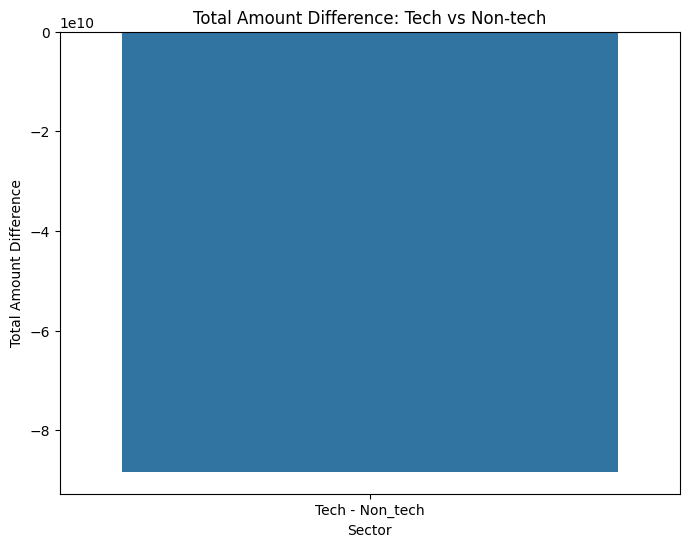

Tech Amount: 15395084703.235012
Non_tech Amount: 103704301355.21567
Difference: -88309216651.98065


In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Amount' is the column containing the financial amounts

# Summing the amounts for 'Tech' and 'Non_tech' sectors
tech_amount = india_startup_df.loc[india_startup_df['Tech'].notnull(), 'Updated_Amount'].sum()
non_tech_amount = india_startup_df.loc[india_startup_df['Non_tech'].notnull(), 'Updated_Amount'].sum()

# Calculate the difference
amount_difference = tech_amount - non_tech_amount

# Creating a bar plot to visualize the comparison
plt.figure(figsize=(8, 6))
sns.barplot(x=['Tech - Non_tech'], y=[amount_difference])
plt.title('Total Amount Difference: Tech vs Non-tech')
plt.xlabel('Sector')
plt.ylabel('Total Amount Difference')
plt.show()

# Display the numerical difference
print(f'Tech Amount: {tech_amount}')
print(f'Non_tech Amount: {non_tech_amount}')
print(f'Difference: {amount_difference}')


Text(0.5, 1.0, 'Total')

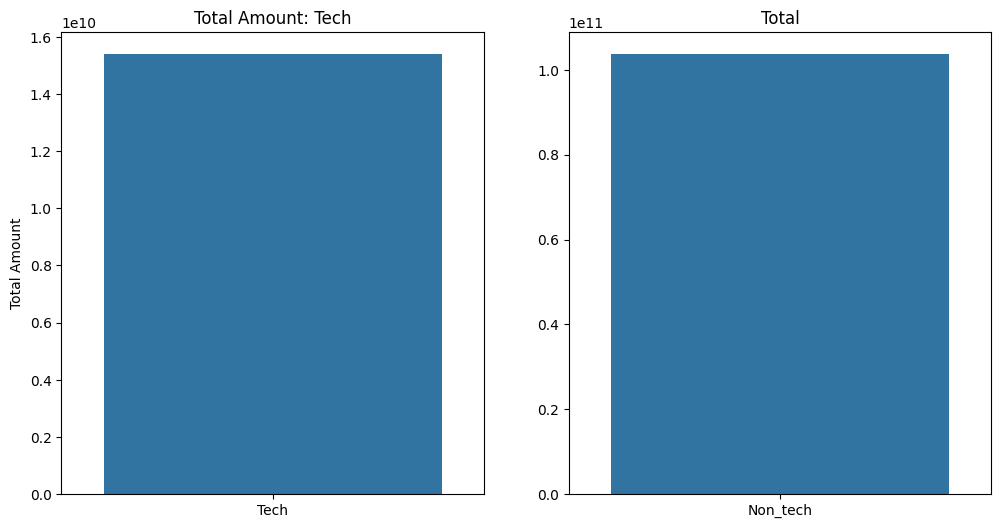

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Amount' is the column containing the financial amounts

# Summing the amounts for 'Tech' and 'Non_tech' sectors
tech_amount = india_startup_df.loc[india_startup_df['Tech'].notnull(), 'Updated_Amount'].sum()
non_tech_amount = india_startup_df.loc[india_startup_df['Non_tech'].notnull(), 'Updated_Amount'].sum()

# Creating separate bar plots for 'Tech' and 'Non_tech'
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot for 'Tech'
sns.barplot(x=['Tech'], y=[tech_amount], ax=axes[0])
axes[0].set_title('Total Amount: Tech')
axes[0].set_ylabel('Total Amount')

# Bar plot for 'Non_tech'
sns.barplot(x=['Non_tech'], y=[non_tech_amount], ax=axes[1])
axes[1].set_title('Total')


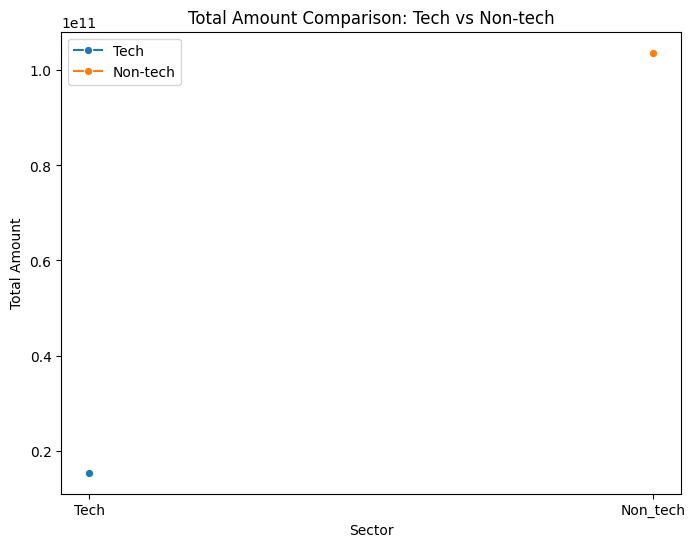

Tech Amount: 15395084703.235012
Non_tech Amount: 103704301355.21567


In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Amount' is the column containing the financial amounts

# Summing the amounts for 'Tech' and 'Non_tech' sectors
tech_amount = india_startup_df.loc[india_startup_df['Tech'].notnull(), 'Updated_Amount'].sum()
non_tech_amount = india_startup_df.loc[india_startup_df['Non_tech'].notnull(), 'Updated_Amount'].sum()

# Creating a line chart to visualize the comparison
plt.figure(figsize=(8, 6))

# Line chart for 'Tech'
sns.lineplot(x=['Tech'], y=[tech_amount], label='Tech', marker='o')

# Line chart for 'Non_tech'
sns.lineplot(x=['Non_tech'], y=[non_tech_amount], label='Non-tech', marker='o')

plt.title('Total Amount Comparison: Tech vs Non-tech')
plt.xlabel('Sector')
plt.ylabel('Total Amount')
plt.legend()
plt.show()

# Display the numerical values
print(f'Tech Amount: {tech_amount}')
print(f'Non_tech Amount: {non_tech_amount}')


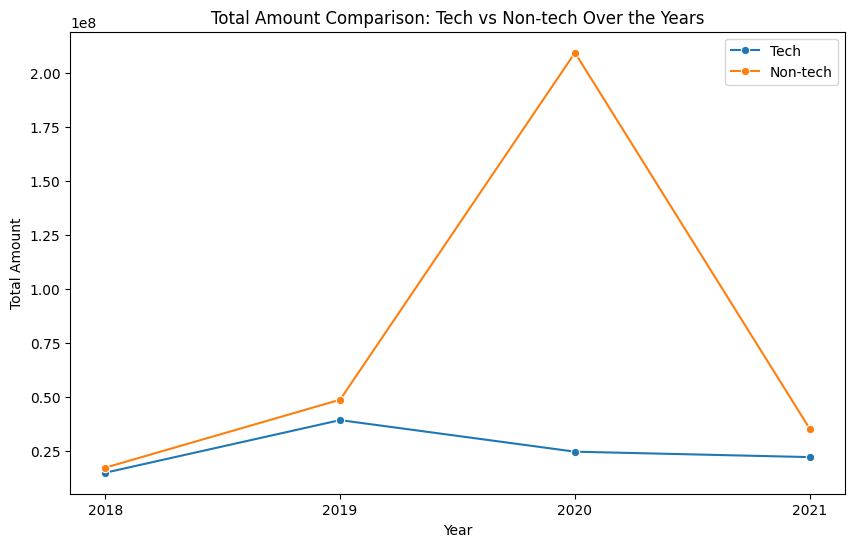

Tech Amount Over Years:
Year
2018    1.512974e+07
2019    3.945833e+07
2020    2.485891e+07
2021    2.235067e+07
Name: Updated_Amount, dtype: float64

Non_tech Amount Over Years:
Year
2018    1.747267e+07
2019    4.889079e+07
2020    2.093262e+08
2021    3.540784e+07
Name: Updated_Amount, dtype: float64


In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Amount' is the column containing the financial amounts
# Assuming 'Year' is the column containing the years

# Summing the amounts for 'Tech' and 'Non_tech' sectors over the years
tech_amount_over_years = india_startup_df.loc[india_startup_df['Tech'].notnull()].groupby('Year')['Updated_Amount'].mean()
non_tech_amount_over_years = india_startup_df.loc[india_startup_df['Non_tech'].notnull()].groupby('Year')['Updated_Amount'].mean()

# Creating a line chart to visualize the comparison over the years
plt.figure(figsize=(10, 6))

# Line chart for 'Tech'
sns.lineplot(x=tech_amount_over_years.index, y=tech_amount_over_years.values, label='Tech', marker='o')

# Line chart for 'Non_tech'
sns.lineplot(x=non_tech_amount_over_years.index, y=non_tech_amount_over_years.values, label='Non-tech', marker='o')

plt.title('Total Amount Comparison: Tech vs Non-tech Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Amount')
plt.legend()
plt.show()

# Display the numerical values
print('Tech Amount Over Years:')
print(tech_amount_over_years)
print('\nNon_tech Amount Over Years:')
print(non_tech_amount_over_years)


In [104]:
from scipy.stats import ttest_ind

# Assuming tech_amount_over_years and non_tech_amount_over_years are pandas Series for total amounts over the years
t_stat, p_value = ttest_ind(tech_amount_over_years, non_tech_amount_over_years, equal_var=False)

# Check the p-value
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference.")


Fail to reject the null hypothesis. There is no significant difference.


In [107]:
from scipy.stats import ttest_ind

# Assuming tech_amount_over_years and non_tech_amount_over_years are pandas Series for total amounts over the years
# Assuming 'Year' is the column containing the years

# Filter data for the year 2020
tech_amount_2020 = tech_amount_over_years.loc[india_startup_df['Year'] == 2020]
non_tech_amount_2020 = non_tech_amount_over_years.loc[india_startup_df['Year'] == 2020]

# Perform t-test
t_stat, p_value = ttest_ind(tech_amount_2020, non_tech_amount_2020, equal_var=False)

# Check the p-value
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference in 2020.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in 2020.")


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).